Monte Carlo Sampling (2) Benchmark Program - Qiskit
... execution starting at Oct 09, 2024 10:49:22 UTC
************
Executing [1] circuits with num_qubits = 4
************
Executing [1] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 202, 0.398
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 208, 0.372, 96.0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.009, 0.262, 0.006 secs
Average Transpiling, Validating, Running Times for group 4 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 0.779, 0.558

************
Executing [1] circuits with num_qubits = 6
************
Average Circuit Algorithmic Depth, ξ (xi) for the 5 qubit group = 468, 0.401
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 5 qubit group = 479, 0.377, 224.0
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.011, 0.573, 0.018 secs
Average Tran

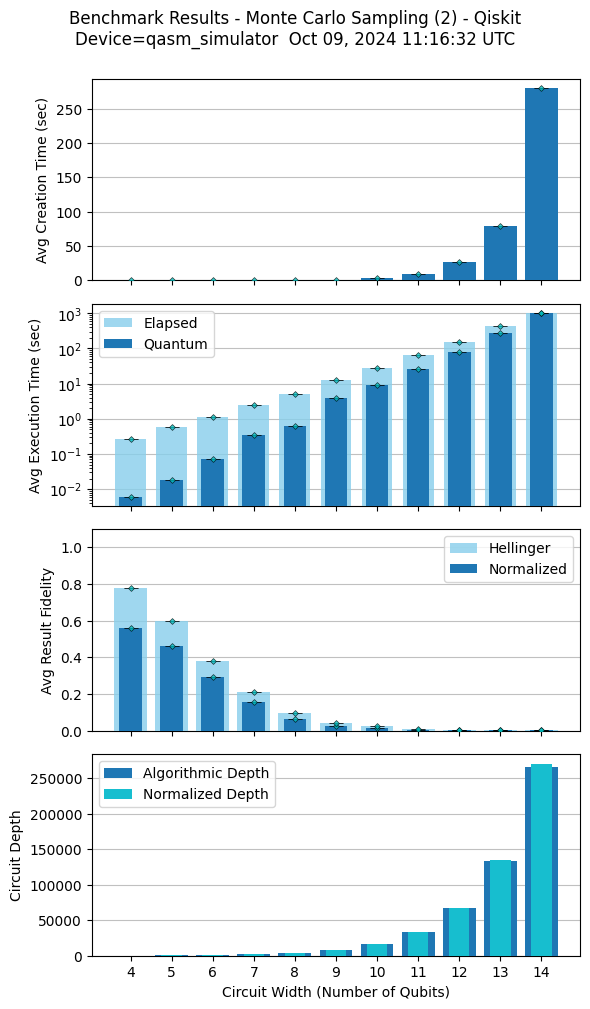

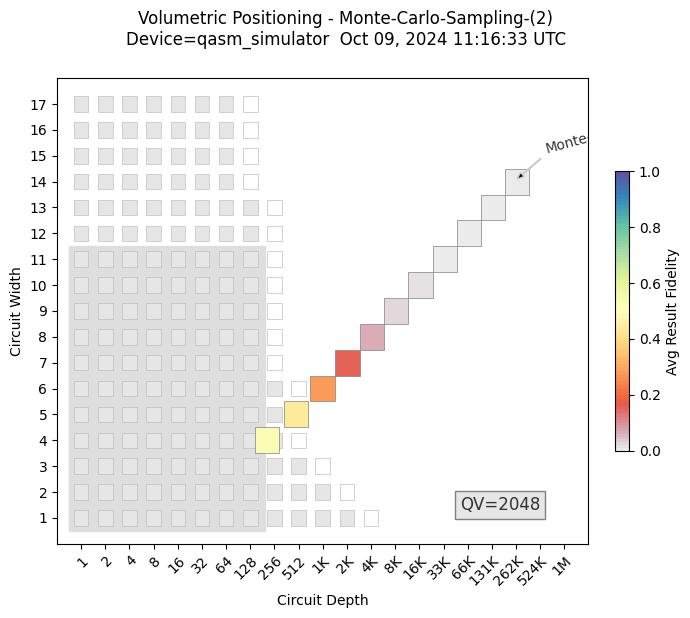

In [1]:
"""
Monte Carlo Sampling Benchmark Program via Amplitude Estimation- Qiskit
"""

import copy
import functools
import sys
import time

import numpy as np
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library.standard_gates.ry import RYGate

sys.path[1:1] = ["_common", "_common/qiskit", "monte-carlo/_common", "quantum-fourier-transform/qiskit"]
sys.path[1:1] = ["../../_common", "../../_common/qiskit", "../../monte-carlo/_common", "../../quantum-fourier-transform/qiskit"]
import execute as ex
import mc_utils as mc_utils
import metrics as metrics
from qft_benchmark import inv_qft_gate

# Benchmark Name
benchmark_name = "Monte Carlo Sampling"

np.random.seed(0)

# default function is f(x) = x^2
f_of_X = functools.partial(mc_utils.power_f, power=2)

# default distribution is gaussian distribution
p_distribution = mc_utils.gaussian_dist

verbose = False

# saved circuits and subcircuits for display
A_ = None
Q_ = None
cQ_ = None
QC_ = None
R_ = None
F_ = None
QFTI_ = None

############### Circuit Definition

def MonteCarloSampling(target_dist, f, num_state_qubits, num_counting_qubits, epsilon=0.05, degree=2, method=2):
    
    A_qr = QuantumRegister(num_state_qubits+1)
    A = QuantumCircuit(A_qr, name="A")

    num_qubits = num_state_qubits + 1 + num_counting_qubits
    
    # initialize R and F circuits
    R_qr = QuantumRegister(num_state_qubits+1)
    F_qr = QuantumRegister(num_state_qubits+1)
    R = QuantumCircuit(R_qr, name="R")
    F = QuantumCircuit(F_qr, name="F")
    
    # method 1 takes in the abitrary function f and arbitrary dist
    if method == 1:
        state_prep(R, R_qr, target_dist, num_state_qubits)
        f_on_objective(F, F_qr, f, epsilon=epsilon, degree=degree)
    # method 2 chooses to have lower circuit depth by choosing specific f and dist
    elif method == 2:
        uniform_prep(R, R_qr, num_state_qubits)
        square_on_objective(F, F_qr)

    # append R and F circuits to A
    A.append(R.to_gate(), A_qr)
    A.append(F.to_gate(), A_qr)

    # run AE subroutine given our A composed of R and F
    qc = AE_Subroutine(num_state_qubits, num_counting_qubits, A, method)

    # save smaller circuit example for display
    global QC_, R_, F_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    if (R_ and F_) == None or num_state_qubits <= 3:
        if num_state_qubits < 5: R_ = R; F_ = F
    
    return qc    

###############              
                    
def f_on_objective(qc, qr, f, epsilon=0.05, degree=2):
    """
    Assume last qubit is the objective. Function f is evaluated on first n-1 qubits
    """
    num_state_qubits = qc.num_qubits - 1
    c_star = (2*epsilon)**(1/(degree+1))
    
    f_ = functools.partial(f, num_state_qubits=num_state_qubits)
    zeta_ = functools.partial(mc_utils.zeta_from_f, func=f_, epsilon=epsilon, degree=degree, c=c_star)
    
    x_eval = np.linspace(0.0, 2**(num_state_qubits) - 1, num= degree+1)
    poly = Polynomial(polyfit(x_eval, zeta_(x_eval), degree))
    
    b_exp = mc_utils.binary_expansion(num_state_qubits, poly)
    
    for controls in b_exp.keys():
        theta = 2*b_exp[controls]
        controls = list(controls)
        if len(controls)==0:
            qc.ry(-theta, qr[num_state_qubits])
        else:
            # define a MCRY gate:
            # this does the same thing as qc.mcry, but is clearer in the circuit printing
            MCRY = RYGate(-theta).control(len(controls))
            qc.append(MCRY, [*(qr[i] for i in controls), qr[num_state_qubits]])

def square_on_objective(qc, qr):
    """
    Assume last qubit is the objective.
    Shifted square wave function: if x is even, f(x) = 0; if x i s odd, f(x) = 1
    """
    num_state_qubits = qc.num_qubits - 1
    for control in range(num_state_qubits):
        qc.cx(control, num_state_qubits)

def state_prep(qc, qr, target_dist, num_state_qubits):
    """
    Use controlled Ry gates to construct the superposition Sum \sqrt{p_i} |i>
    """
    r_probs = mc_utils.region_probs(target_dist, num_state_qubits)
    regions = r_probs.keys()
    r_norm = {}
    
    for r in regions:
        num_controls = len(r) - 1
        super_key = r[:num_controls]

        if super_key=='':
            r_norm[super_key] = 1
        elif super_key == '1':
            r_norm[super_key] = r_probs[super_key]
            r_norm['0'] = 1-r_probs[super_key]
        else:
            try:
                r_norm[super_key] = r_probs[super_key]
                
            except KeyError:
                r_norm[super_key] = r_norm[super_key[:num_controls-1]] - r_probs[super_key[:num_controls-1] + '1']
        
        
        norm = r_norm[super_key]
        p = 0
        if norm != 0:
            p = r_probs[r] / norm
        theta = 2*np.arcsin(np.sqrt(p))
        
        if r == '1':
            qc.ry(-theta, num_state_qubits-1)
        else:
            controls = [qr[num_state_qubits-1 - i] for i in range(num_controls)]
            
            # define a MCRY gate:
            # this does the same thing as qc.mcry, but is clearer in the circuit printing
            MCRY = RYGate(-theta).control(num_controls, ctrl_state=r[:-1])
            qc.append(MCRY, [*controls, qr[num_state_qubits-1 - num_controls]])

def uniform_prep(qc, qr, num_state_qubits):
    """
    Generates a uniform distribution over all states
    """
    for i in range(num_state_qubits):
        qc.h(i)
            
def AE_Subroutine(num_state_qubits, num_counting_qubits, A_circuit, method):

    num_qubits = num_state_qubits + num_counting_qubits
    
    qr_state = QuantumRegister(num_state_qubits+1)
    qr_counting = QuantumRegister(num_counting_qubits)
    cr = ClassicalRegister(num_counting_qubits)
    qc = QuantumCircuit(qr_state, qr_counting, cr, name=f"qmc({method})-{num_qubits}-{0}")

    A = A_circuit
    cQ, Q = Ctrl_Q(num_state_qubits, A)

    # save small example subcircuits for visualization
    global A_, Q_, cQ_, QFTI_
    if (cQ_ and Q_) == None or num_state_qubits <= 6:
        if num_state_qubits < 9: cQ_ = cQ; Q_ = Q
    if A_ == None or num_state_qubits <= 3:
        if num_state_qubits < 5: A_ = A
    if QFTI_ == None or num_counting_qubits <= 3:
        if num_counting_qubits < 4: QFTI_ = inv_qft_gate(num_counting_qubits)

    # Prepare state from A, and counting qubits with H transform 
    qc.append(A, qr_state)
    for i in range(num_counting_qubits):
        qc.h(qr_counting[i])
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        for _ in range(repeat):
            qc.append(cQ, [qr_counting[j]] + [qr_state[l] for l in range(num_state_qubits+1)])
        repeat *= 2
    
    qc.barrier()
    
    # inverse quantum Fourier transform only on counting qubits
    qc.append(inv_qft_gate(num_counting_qubits), qr_counting)
    
    qc.barrier()
    
    qc.measure([qr_counting[m] for m in range(num_counting_qubits)], list(range(num_counting_qubits)))
    
    return qc
            
            
###############################
   
# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qc = QuantumCircuit(num_state_qubits+1, name="Q")
    
    temp_A = copy.copy(A_circ)
    A_gate = temp_A.to_gate()
    A_gate_inv = temp_A.inverse().to_gate()
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc.x(num_state_qubits)
    qc.z(num_state_qubits)
    qc.x(num_state_qubits)
        
    # A_circ_inverse
    qc.append(A_gate_inv, [i for i in range(num_state_qubits+1)])
        
    # S_0
    for i in range(num_state_qubits+1):
        qc.x(i)
    qc.h(num_state_qubits)
    
    qc.mcx([x for x in range(num_state_qubits)], num_state_qubits)
    
    qc.h(num_state_qubits)
    for i in range(num_state_qubits+1):
        qc.x(i)
        
    # A_circ
    qc.append(A_gate, [i for i in range(num_state_qubits+1)])
    
    # Create a gate out of the Q operator
    qc.to_gate(label='Q')
    
    # and also a controlled version of it
    Ctrl_Q_ = qc.control(1)
    
    # and return both
    return Ctrl_Q_, qc

#########################################

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_counting_qubits, mu, num_shots, method, num_state_qubits):

    # generate exact value for the expectation value given our function and dist
    target_dist = p_distribution(num_state_qubits, mu)
    f = functools.partial(f_of_X, num_state_qubits=num_state_qubits)
    if method == 1:
        exact = mc_utils.estimated_value(target_dist, f)
    elif method == 2:
        exact = 0.5 # hard coded exact value from uniform dist and square function

    # obtain counts from the result object
    counts = result.get_counts(qc)
 
    # calculate the expected output histogram
    correct_dist = a_to_bitstring(exact, num_counting_qubits)

    # generate thermal_dist with amplitudes instead, to be comparable to correct_dist
    thermal_dist = metrics.uniform_dist(num_counting_qubits)   

    # convert counts, expectation, and thermal_dist to app form for visibility
    # app form of correct distribution is measuring the input a 100% of the time
    # convert bit_counts into expectation values counts according to Quantum Risk Analysis paper
    app_counts = expectation_from_bits(counts, num_counting_qubits, num_shots, method)
    app_correct_dist = mc_utils.mc_dist(num_counting_qubits, exact, c_star, method)
    app_thermal_dist = expectation_from_bits(thermal_dist, num_counting_qubits, num_shots, method)
    
    if verbose:
        print(f"For expected value {exact}, expected: {correct_dist} measured: {counts}")
        print(f"   ... For expected value {exact} thermal_dist: {thermal_dist}")
        print(f"For expected value {exact}, app expected: {app_correct_dist} measured: {app_counts}")
        print(f"   ... For expected value {exact} app_thermal_dist: {app_thermal_dist}")
        
    # use polarization fidelity with rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)
    #fidelity = metrics.polarization_fidelity(app_counts, app_correct_dist, app_thermal_dist)
    
    hf_fidelity = metrics.hellinger_fidelity_with_expected(counts, correct_dist)
    
    ###########################################################################
    # NOTE: in this benchmark, we are testing how well the amplitude estimation routine
    #       works according to theory, and we do not measure the difference between
    #       the reported answer and the correct answer; the below code just helps
    #       demonstrate that we do approximate the expectation value accurately.

    # the max in the counts is what the algorithm would report as the correct answer
    a, _ = mc_utils.value_and_max_prob_from_dist(counts)

    if verbose: print(f"For expected value {exact} measured: {a}")
    ###########################################################################

    if verbose: print(f"Solution counts: {counts}")
    
    if verbose: print(f"  ... fidelity: {fidelity}  hf_fidelity: {hf_fidelity}")
    
    return counts, fidelity

def a_to_bitstring(a, num_counting_qubits):
    m = num_counting_qubits

    # solution 1
    num1 = round(np.arcsin(np.sqrt(a)) / np.pi * 2**m)
    num2 = round( (np.pi - np.arcsin(np.sqrt(a))) / np.pi * 2**m)
    if num1 != num2 and num2 < 2**m and num1 < 2**m:
        counts = {format(num1, "0"+str(m)+"b"): 0.5, format(num2, "0"+str(m)+"b"): 0.5}
    else:
        counts = {format(num1, "0"+str(m)+"b"): 1}
    return counts

def expectation_from_bits(bits, num_qubits, num_shots, method):
    amplitudes = {}
    for b in bits.keys():
        precision = int(num_qubits / (np.log2(10))) + 2

        r = bits[b]
        a_meas = pow(np.sin(np.pi*int(b,2)/pow(2,num_qubits)),2)
        if method == 1:
            a = ((a_meas - 0.5)/c_star) + 0.5
        if method == 2:
            a = a_meas
        a = round(a, precision)
        
        if a not in amplitudes.keys():
            amplitudes[a] = 0
        amplitudes[a] += r
    
    return amplitudes

################ Benchmark Loop

MIN_QUBITS = 4    # must be at least MIN_STATE_QUBITS + 3
MIN_STATE_QUBITS = 1

# set minimums for method 1
MIN_QUBITS_M1 = 5 # must be at least MIN_STATE_QUBITS + 3
MIN_STATE_QUBITS_M1 = 2

# Because circuit size grows significantly with num_qubits
# limit the max_qubits here ...
MAX_QUBITS=17     #increasing the value will take longer time to execute

# Execute program with default parameters
def run(min_qubits=MIN_QUBITS, max_qubits=14, skip_qubits=1, max_circuits=1, num_shots=1000,
        epsilon=0.05, degree=2, num_state_qubits=MIN_STATE_QUBITS, method = 2, # default, not exposed to users
        backend_id='qasm_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit")

    # Clamp the maximum number of qubits
    if max_qubits > MAX_QUBITS:
        print(f"INFO: {benchmark_name} benchmark is limited to a maximum of {MAX_QUBITS} qubits.")
        max_qubits = MAX_QUBITS
    
    if (method == 2):
        if max_qubits < MIN_QUBITS:
            print(f"INFO: {benchmark_name} benchmark method ({method}) requires a minimum of {MIN_QUBITS} qubits.")
            return
        if min_qubits < MIN_QUBITS:
            min_qubits = MIN_QUBITS
    
    elif (method == 1):
        if max_qubits < MIN_QUBITS_M1:
            print(f"INFO: {benchmark_name} benchmark method ({method}) requires a minimum of {MIN_QUBITS_M1} qubits.")
            return
        if min_qubits < MIN_QUBITS_M1:
            min_qubits = MIN_QUBITS_M1

    if (method == 1) and (num_state_qubits == MIN_STATE_QUBITS):
        num_state_qubits = MIN_STATE_QUBITS_M1
    
    skip_qubits = max(1, skip_qubits)
    ### TODO: need to do more validation of arguments, e.g. min_state_qubits and min_qubits

    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()
    
    global c_star
    c_star = (2*epsilon)**(1/(degree+1))

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, mu, num_shots):
        # determine fidelity of result set
        num_counting_qubits = int(num_qubits) - num_state_qubits -1
        counts, fidelity = analyze_and_print_result(qc, result, num_counting_qubits, float(mu), num_shots, method=method, num_state_qubits=num_state_qubits)
        metrics.store_metric(num_qubits, mu, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):

        # reset random seed
        np.random.seed(0)

        input_size = num_qubits - 1 # TODO: keep using inputsize? only used in num_circuits
        
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (input_size), max_circuits)
        #print(num_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # determine range of circuits to loop over for method 1
        if 2**(input_size) <= max_circuits:
            mu_range = [i/2**(input_size) for i in range(num_circuits)]
        else:
            mu_range = [i/2**(input_size) for i in np.random.choice(2**(input_size), num_circuits, False)]

        #print(mu_range)
        
        # loop over limited # of mu values for this
        for mu in mu_range:
            target_dist = p_distribution(num_state_qubits, mu)
            f_to_estimate = functools.partial(f_of_X, num_state_qubits=num_state_qubits)
            
            #print(mu)
            
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            qc = MonteCarloSampling(target_dist, f_to_estimate, num_state_qubits, num_counting_qubits, epsilon, degree, method=method)
            metrics.store_metric(num_qubits, mu, 'create_time', time.time() - ts)
            
            # collapse the 4 sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose().decompose().decompose().decompose()
                
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, mu, num_shots)

            # if method is 2, we only have one type of circuit, so break out of loop
            #if method == 2:
            #    break
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nControlled Quantum Operator 'cQ' ="); print(cQ_ if cQ_ != None else " ... too large!")
    print("\nQuantum Operator 'Q' ="); print(Q_ if Q_ != None else " ... too large!")
    print("\nAmplitude Generator 'A' ="); print(A_ if A_ != None else " ... too large!")
    print("\nDistribution Generator 'R' ="); print(R_ if R_ != None else " ... too large!")
    print("\nFunction Generator 'F' ="); print(F_ if F_ != None else " ... too large!")
    print("\nInverse QFT Circuit ="); print(QFTI_ if QFTI_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit")
       
        
# if main, execute method
if __name__ == '__main__': run()
